In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D,
    ZeroPadding2D, Activation, Dense, Flatten, Input, Add, ReLU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications import resnet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
from keras.layers import Input, Conv2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Add
from keras.models import Model
from keras.regularizers import l2
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
sns.set(style='white', context='notebook', palette='deep')

In [2]:
datapath = '/kaggle/input/wikiart'
genres_datapath = '/kaggle/input/genres-ds'
# Load and process genre_class.txt
data_classes = pd.read_csv(genres_datapath+'/genre_class.txt')
data_classes = {}
with open(genres_datapath + '/genre_class.txt', 'r') as f:
    for line in f:
        index, label = line.strip().split(' ', 1)
        data_classes[int(index)] = label
print(data_classes)

{0: 'abstract_painting', 1: 'cityscape', 2: 'genre_painting', 3: 'illustration', 4: 'landscape', 5: 'nude_painting', 6: 'portrait', 7: 'religious_painting', 8: 'sketch_and_study', 9: 'still_life'}


In [3]:
# Load train and validation data
data_valid = pd.read_csv(genres_datapath+'/genre_val.csv')
data_train = pd.read_csv(genres_datapath+'/genre_train.csv')
data_train.head()

,filename,genre
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3
2,Expressionism/martiros-saryan_mother-of-the-ar...,6
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6


In [4]:
# Map labels to class names in train data
data_train['class_name'] = data_train['genre'].map(data_classes)
data_valid['class_name'] = data_valid['genre'].map(data_classes)
data_train.head()

,filename,genre,class_name
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4,landscape
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3,illustration
2,Expressionism/martiros-saryan_mother-of-the-ar...,6,portrait
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8,sketch_and_study
4,Expressionism/jose-gutierrez-solana_old-mounta...,6,portrait


In [5]:
# Check for missing values
print(f"train:\n{data_train.isnull().sum()}\n")
print(f"validation:\n{data_valid.isnull().sum()}")

train:
filename      0
genre         0
class_name    0
dtype: int64

validation:
filename      0
genre         0
class_name    0
dtype: int64


In [7]:
# Function to identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for filename in dataframe['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames_train = find_invalid_filenames(data_train, datapath)
invalid_filenames_valid = find_invalid_filenames(data_valid, datapath)

print(f"Number of invalid files in train data: {len(invalid_filenames_train)}")
print(f"Number of invalid files in valid data: {len(invalid_filenames_valid)}")

Number of invalid files in train data: 423
Number of invalid files in valid data: 193


In [8]:
# Remove invalid filenames from both train and validation datasets
data_train_cleaned = data_train[~data_train['filename'].isin(invalid_filenames_train)]
print(f"Number of valid rows in train after cleaning: {len(data_train_cleaned)}")

data_valid_cleaned = data_valid[~data_valid['filename'].isin(invalid_filenames_valid)]
print(f"Number of valid rows in valid after cleaning: {len(data_valid_cleaned)}")


Number of valid rows in train after cleaning: 45079
Number of valid rows in valid after cleaning: 19298


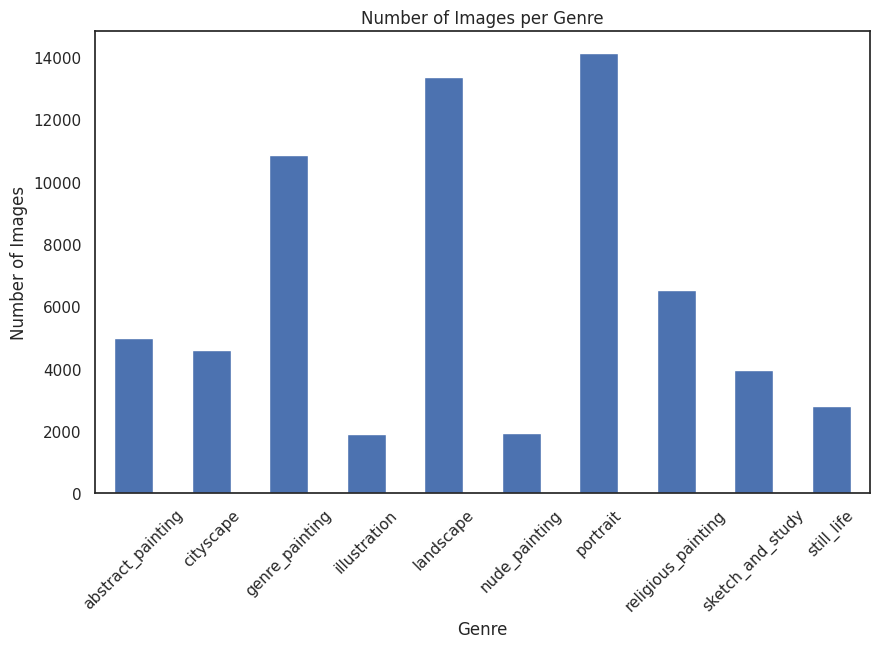

In [9]:
# Visualize the genres distribution
combined_data = (data_train['class_name'].value_counts() + data_valid['class_name'].value_counts())
combined_data.sort_index().plot(kind='bar', figsize=(10, 6), legend=False)
plt.title("Number of Images per Genre")
plt.ylabel("Number of Images")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.show()

In [10]:
# Split the training data into training and testing sets (80% train, 20% test)
data_train, data_test = train_test_split(data_train, test_size=0.2, random_state=42, stratify=data_train['genre'])
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(36401, 3)
(19491, 3)
(9101, 3)


In [11]:
# Balance classes for training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data_train['class_name']),
    y=data_train['class_name']
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

{0: 1.3084471603163192, 1: 1.4119860356865788, 2: 0.5986022035849367, 3: 3.414727954971857, 4: 0.48657933431359446, 5: 3.376716141001855, 6: 0.46053896761133606, 7: 0.9942911772739689, 8: 1.6478497057492079, 9: 2.3319026265214604}


In [12]:
# Apply augmentation on training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_train,
    directory=datapath,
    x_col='filename',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

# Validation generator
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=data_valid_cleaned,
    directory=datapath,
    x_col='filename',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

# Testing generator
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_test,
    directory=datapath,
    x_col='filename',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

Found 36065 validated image filenames belonging to 10 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 336 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 19298 validated image filenames belonging to 10 classes.
Found 9014 validated image filenames belonging to 10 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 87 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


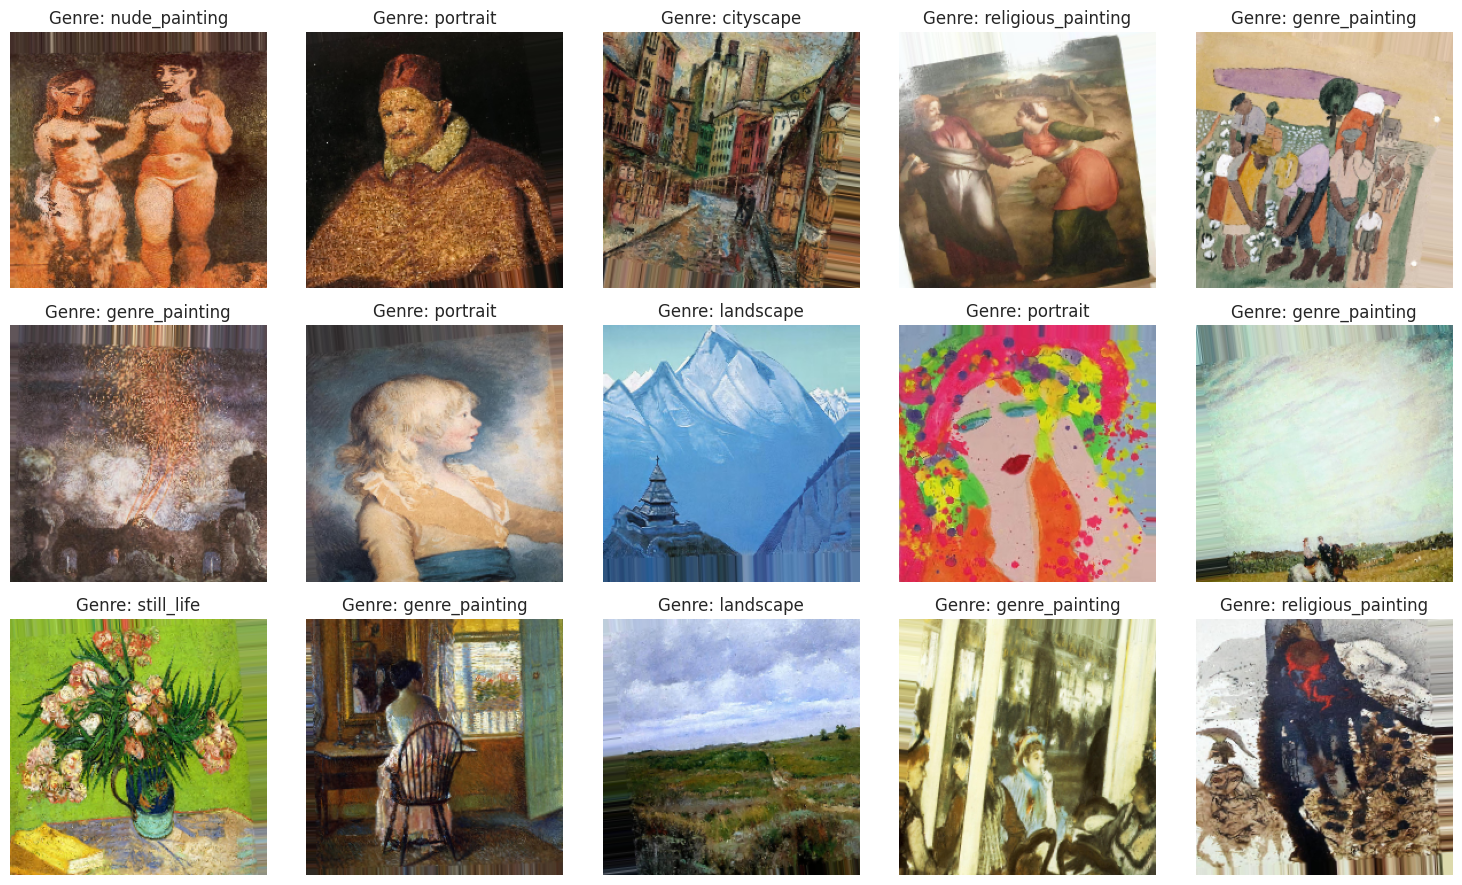

In [13]:
# Visualize images and labels from a batch of the train generator
image_batch, label_batch = next(train_generator)
plt.figure(figsize=(15, 9))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(image_batch[i])
    plt.title(f"Genre: {data_classes[np.argmax(label_batch[i])]}", fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


# Hyperparameters
num_epochs = 15
num_classes = 10 
learning_rate = 0.00005

# Define the input layer
inputs = Input(shape=(224, 224, 3))

# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Add custom layers on top of the DenseNet base model
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)


# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [16]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs= num_epochs
                   )

Epoch 1/15
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1550s 1s/step - accuracy: 0.4023 - loss: 1.7606 - val_accuracy: 0.6206 - val_loss: 1.1301
Epoch 2/15
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1303s 1s/step - accuracy: 0.5941 - loss: 1.1894 - val_accuracy: 0.6564 - val_loss: 1.0099
Epoch 3/15
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1125s 993ms/step - accuracy: 0.6299 - loss: 1.0804 - val_accuracy: 0.6698 - val_loss: 0.9601
Epoch 4/15
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1101s 971ms/step - accuracy: 0.6542 - loss: 1.0153 - val_accuracy: 0.6749 - val_loss: 0.9388
Epoch 5/15
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1101s 972ms/step - accuracy: 0.6564 - loss: 1.0003 - val_accuracy: 0.6818 - val_loss: 0.9159
Epoch 6/15
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1105s 976ms/step - accuracy: 0.6641 - loss: 0.9688 - val_accuracy: 0.6846 - val_loss: 0.9068
Epoch 7/15
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1238s 1s/step - accuracy: 0.6735 - loss: 0.9475 - val_accuracy: 0.6874 - val_loss: 0.8947
Epoch 8/15
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1121s 989ms/step - acc

In [35]:
# Fine-tuning: Unfreeze some of the final layers of DenseNet

base_model.trainable = True  # Unfreeze the last few layers of the DenseNet base model

# Set the number of layers to fine-tune
fine_tune_at = len(base_model.layers) - 100  # last 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
#for i, layer in enumerate(base_model.layers):
#    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")
    
# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
finetuning_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    initial_epoch = 0,
    verbose=1
)

Epoch 1/10
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1304s 1s/step - accuracy: 0.6501 - loss: 1.0064 - val_accuracy: 0.6995 - val_loss: 0.8636
Epoch 2/10
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1257s 1s/step - accuracy: 0.6899 - loss: 0.8945 - val_accuracy: 0.7070 - val_loss: 0.8415
Epoch 3/10
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1204s 1s/step - accuracy: 0.7077 - loss: 0.8500 - val_accuracy: 0.7126 - val_loss: 0.8226
Epoch 4/10
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1191s 1s/step - accuracy: 0.7133 - loss: 0.8235 - val_accuracy: 0.7169 - val_loss: 0.8090
Epoch 5/10
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1296s 1s/step - accuracy: 0.7232 - loss: 0.8024 - val_accuracy: 0.7185 - val_loss: 0.8016
Epoch 6/10
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1187s 1s/step - accuracy: 0.7273 - loss: 0.7733 - val_accuracy: 0.7237 - val_loss: 0.7924
Epoch 7/10
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1179s 1s/step - accuracy: 0.7305 - loss: 0.7727 - val_accuracy: 0.7256 - val_loss: 0.7857
Epoch 8/10
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 1311s 1s/step - accuracy: 0.7395 -

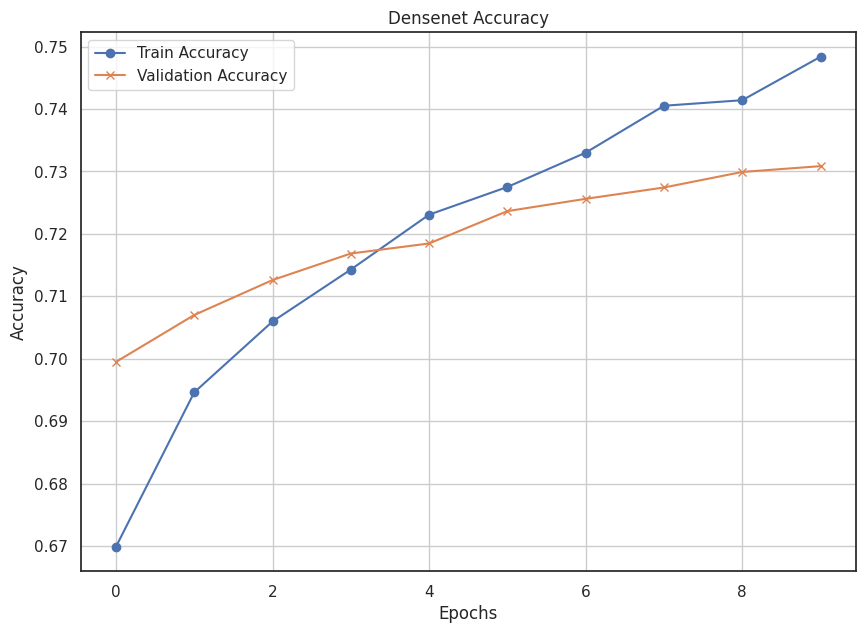

In [36]:
def plot_accuracy(history, model_name='Densenet'):
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_accuracy(finetuning_history)

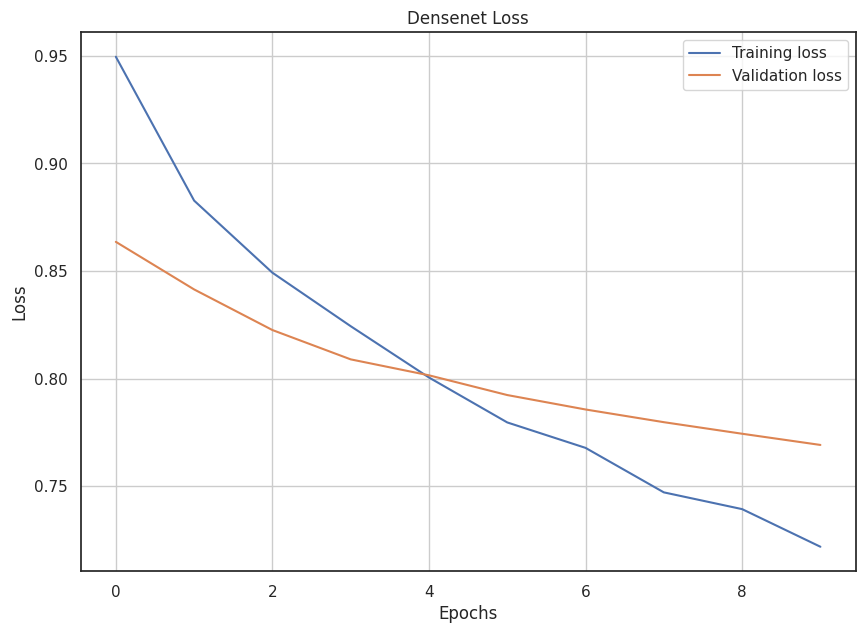

In [37]:
# Plot training & validation loss values
plt.figure(figsize=(10, 7))

# Plot Loss
plt.plot(finetuning_history.history['loss'], label='Training loss')
plt.plot(finetuning_history.history['val_loss'], label='Validation loss')
plt.title('Densenet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [39]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator, batch_size=32, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

282/282 ━━━━━━━━━━━━━━━━━━━━ 206s 733ms/step - accuracy: 0.7381 - loss: 0.7517
Test Loss: 0.7473782896995544
Test Accuracy: 73.84%


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    RocCurveDisplay
)

# Predict on the test set
y_pred_prob = model.predict(test_generator)  # Get predicted probabilities


282/282 ━━━━━━━━━━━━━━━━━━━━ 169s 599ms/step


In [42]:
y_pred = np.argmax(y_pred_prob, axis=1)      # Get predicted class indices
y_true = test_generator.classes               # Get true class indices
#y_true_arr = np.argmax(y_true, axis=1)     
#y_true_arr
#y_pred

# Class labels
class_labels = list(test_generator.class_indices.keys())


# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Generate and print the Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(report)



Test Accuracy: 73.84%
Classification Report:
                    precision    recall  f1-score   support

 abstract_painting       0.87      0.86      0.86       696
         cityscape       0.73      0.63      0.68       642
    genre_painting       0.60      0.57      0.59      1483
      illustration       0.47      0.55      0.51       264
         landscape       0.80      0.87      0.84      1846
     nude_painting       0.67      0.50      0.57       269
          portrait       0.79      0.84      0.81      1964
religious_painting       0.72      0.71      0.71       910
  sketch_and_study       0.65      0.60      0.62       551
        still_life       0.80      0.78      0.79       389

          accuracy                           0.74      9014
         macro avg       0.71      0.69      0.70      9014
      weighted avg       0.74      0.74      0.74      9014



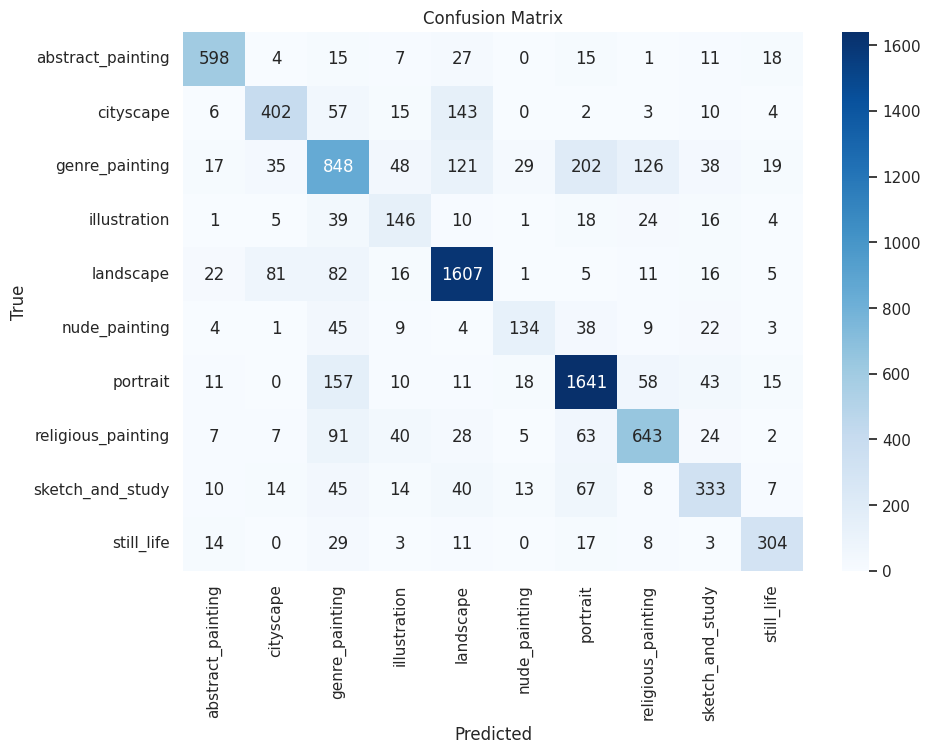

In [43]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [44]:
print(type(y_true))
y_true_arr =np.array(y_true)
print(type(y_true_arr))

<class 'list'>
<class 'numpy.ndarray'>


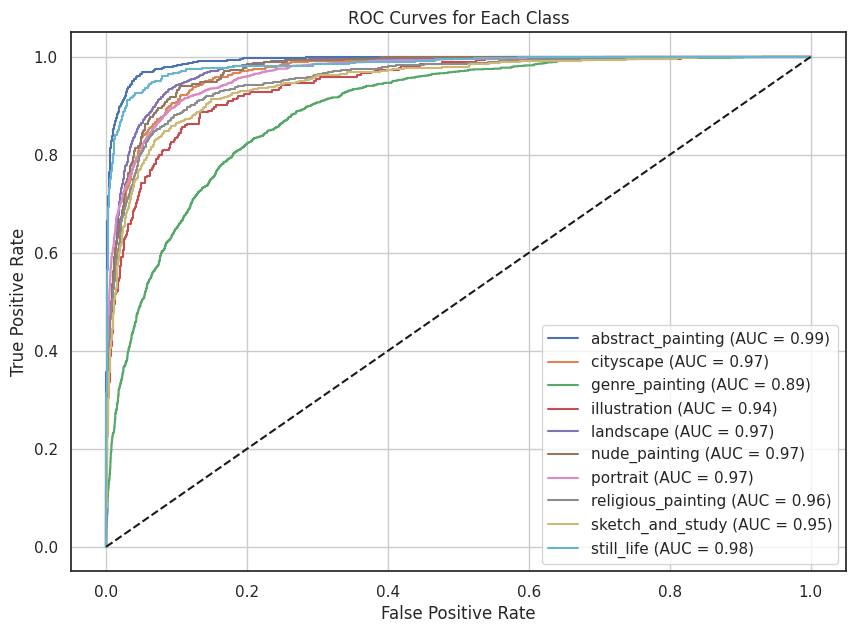

In [48]:
# ROC and AUC for each class

plt.figure(figsize=(10, 7))
for i in range(len(class_labels)):
    # Ensure y_true is being compared element-wise to i
    y_true_binary = (y_true_arr == i).astype(int)
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='best')
plt.grid()
plt.show()